In [1]:
import os
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusDelegationMechanism,
    StudentExpertDelegationMechanism,
)
from exp_framework.learning import Net
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from avalanche.training.supervised import Naive
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
from avalanche.benchmarks.classic import RotatedMNIST, SplitMNIST
import numpy as np
import matplotlib as mpl
import seaborn as sns
from itertools import product
import pandas as pd
import torch.optim as optim
from torch.nn import CrossEntropyLoss

from avalanche.training.plugins import (
    CWRStarPlugin,
    ReplayPlugin,
    EWCPlugin,
    TrainGeneratorAfterExpPlugin,
    LwFPlugin,
    SynapticIntelligencePlugin,
)
from exp_framework.MinibatchEvalAccuracy import MinibatchEvalAccuracy
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

from avalanche.training import EWC

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

### Set up global experiment settings

In [2]:
batch_size = 128
window_size = 50
num_trials = 10
n_voters = 8

#### Create Delegation Mechanisms

### Create Delegation Mechanisms and Ensembles

For simplicity, only explore full ensemble and variants of ProbaSlopeDelegationMechanism since they can be created programmatically.

In [3]:
def get_ensembles_dict(lo_num_gurus=[1, 2, 3, 4]):
    NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)
    NOOP_del_mech2 = DelegationMechanism(batch_size=batch_size, window_size=window_size)

    probability_functions = [
        "random_better",
        "probabilistic_better",
        "probabilistic_weighted",
        "max_diversity",
    ]
    score_functions = [
        "accuracy_score",
        "balanced_accuracy_score",
        "f1_score",
        # "precision_score",
        # "recall_score",
        # "top_k_accuracy_score",
        # "roc_auc_score",
        # "log_loss_score",
        # "max_diversity",
    ]
    # probability_functions = ["max_diversity"]
    # score_functions = ["accuracy_score"]

    del_mechs = {"full-ensemble": NOOP_del_mech}
    for prob_func, score_func in product(probability_functions, score_functions):
        for num_gurus in lo_num_gurus:
            dm = ProbaSlopeDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active=num_gurus,
                probability_function=prob_func,
                score_method=score_func,
            )
            del_mechs[f"{prob_func}-{score_func}-num_gurus-{num_gurus}"] = dm

    for num_gurus_train in lo_num_gurus:
        for num_gurus_test in lo_num_gurus:
            dm = StudentExpertDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active_train=num_gurus_train,
                max_active_test=num_gurus_test,
            )
            del_mechs[
                f"StudentExpert-num_gurus_train-{num_gurus_train}-num_gurus_test-{num_gurus_test}"
            ] = dm

    ensembles_dict = {
        dm_name: Ensemble(
            training_epochs=1,
            n_voters=n_voters,
            delegation_mechanism=dm,
            name=dm_name,
            input_dim=28 * 28,
            output_dim=10,
        )
        for dm_name, dm in del_mechs.items()
    }
    ensembles_dict["single_Net"] = Ensemble(
        training_epochs=1,
        n_voters=1,
        delegation_mechanism=NOOP_del_mech2,
        name="single_Net",
        input_dim=28 * 28,
        output_dim=10,
        width=512,
    )
    return ensembles_dict

#### Create Avalanche Strategies to Compare Against

In [4]:
def initialize_strategies_to_evaluate():
    plugins_to_evaluate = {
        "LwF": LwFPlugin(),
        "EWC": EWCPlugin(ewc_lambda=0.001),
        "SynapticIntelligence": SynapticIntelligencePlugin(si_lambda=0.5),
        # "Replay": ReplayPlugin(mem_size=100),
    }

    strategies_to_evaluate = {}
    for name, pte in plugins_to_evaluate.items():
        model = Net(input_dim=28 * 28, output_dim=10, width=512)
        optimize = optim.Adam(model.parameters(), lr=0.001)

        mb_eval = MinibatchEvalAccuracy()
        evp = EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            mb_eval,
        )
        cl_strategy = Naive(
            model=model,
            optimizer=optimize,
            criterion=CrossEntropyLoss(),
            train_mb_size=batch_size,
            train_epochs=1,
            eval_mb_size=batch_size,
            # plugins=[pte, evp],
            plugins=[pte, evp, mb_eval],
        )
        # cl_strategy = EWC(
        #     model=model,
        #     optimizer=optimize,
        #     criterion=CrossEntropyLoss(),
        #     ewc_lambda=0.001,
        #     train_mb_size=batch_size,
        #     train_epochs=1,
        #     eval_mb_size=batch_size,
        # )
        strategies_to_evaluate[name] = (cl_strategy, evp)

    return strategies_to_evaluate

# Run Experiment

### Train Ensemble - single active voter

In [5]:
# Train ensembles - single guru

data = SplitMNIST(n_experiences=5, fixed_class_order=list(range(10)))


ensembles_dict = get_ensembles_dict()

exp = Experiment(
    n_trials=num_trials,
    ensembles=list(ensembles_dict.values()),
    benchmark=data,
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/10 [00:00<?, ?it/s]

Starting trial  0


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 70.92it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0674
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9867
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 70.34it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0781
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9871
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 59.09it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0813
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9817
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 65.36it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4756
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8586
-- >> End of training phase << --
-- >> Start of train

 10%|█         | 1/10 [12:21<1:51:10, 741.11s/it]

Starting trial  1


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 67.72it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0804
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9856
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.60it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0769
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9864
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 61.98it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0724
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9914
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 64.88it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3031
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8569
-- >> End of training phase << --
-- >> Start of train

 20%|██        | 2/10 [24:35<1:38:16, 737.02s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0846
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9728
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.4740
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1929
Starting trial  2


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 71.29it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0680
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9875
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 72.87it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0687
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9868
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 62.28it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0794
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9869
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 64.04it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2035
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8696
-- >> End of training phase << --
-- >> Start of train

 30%|███       | 3/10 [36:47<1:25:44, 734.93s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1008
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9692
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.1705
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1922
Starting trial  3


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 74.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0585
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9890
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 76.17it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0823
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9882
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 64.40it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0643
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9898
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 67.98it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3549
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8714
-- >> End of training phase << --
-- >> Start of train

 40%|████      | 4/10 [48:58<1:13:20, 733.35s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0651
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9743
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.6083
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1932
Starting trial  4


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 73.93it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0755
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9855
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 70.46it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0748
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9888
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 61.44it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0657
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9879
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 63.35it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2358
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8831
-- >> End of training phase << --
-- >> Start of train

 50%|█████     | 5/10 [1:01:12<1:01:07, 733.43s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0854
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9758
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 11.5477
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1935
Starting trial  5


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 73.00it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0703
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9872
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 74.86it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0899
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9789
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 64.75it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0741
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9874
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 65.79it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9476
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8756
-- >> End of training phase << --
-- >> Start of train

 60%|██████    | 6/10 [1:13:16<48:40, 730.24s/it]  


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0794
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9733
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 9.1099
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1930
Starting trial  6


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 75.05it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0765
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9867
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 75.35it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0693
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9849
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 63.74it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0714
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9856
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 65.97it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1399
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8801
-- >> End of training phase << --
-- >> Start of train

 70%|███████   | 7/10 [1:25:14<36:18, 726.16s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0929
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9662
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.2019
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1916
Starting trial  7


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 74.68it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0725
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9871
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 73.53it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0704
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9867
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 63.00it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0707
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9898
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 65.61it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0049
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8850
-- >> End of training phase << --
-- >> Start of train

 80%|████████  | 8/10 [1:37:08<24:05, 722.51s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0714
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9753
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.9061
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1934
Starting trial  8


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 76.73it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0724
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9878
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 74.24it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0802
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9863
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 63.71it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0724
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9873
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 65.95it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9371
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8828
-- >> End of training phase << --
-- >> Start of train

 90%|█████████ | 9/10 [1:48:56<11:57, 717.76s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0733
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9753
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.7437
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1934
Starting trial  9


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 76.34it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0765
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9875
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 77.63it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0621
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9878
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 63.41it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0743
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9899
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:01<00:00, 67.87it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3211
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8762
-- >> End of training phase << --
-- >> Start of train

100%|██████████| 10/10 [2:00:28<00:00, 722.86s/it]


### Save and Print Results

In [6]:
batch_metrics = exp.get_aggregate_batch_metrics()
dfs = []
for ens, metric_dict in batch_metrics.items():
    df = pd.DataFrame.from_dict(metric_dict, orient="index")
    df["ensemble_name"] = ens
    dfs.append(df)
single_active_df = pd.concat(dfs)
col_order = [len(single_active_df.columns) - 1] + list(
    range(len(single_active_df.columns) - 1)
)
single_active_df = single_active_df[single_active_df.columns[col_order]]
file_prefix = f"class_incremental_single_guru-trials={num_trials}-batch_size={batch_size}_window_size={window_size}-feb11"
path = "results"

if not os.path.exists(path):
    os.mkdir(path)

filepath = f"{path}/{file_prefix}.csv"
single_active_df.to_csv(filepath)

In [7]:
# Print results - single guru

print(f"Results for mechanisms")

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(exp, ens_name, num_trials)
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(exp, strat_name, num_trials)
    train_results_dict[strat_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(
        f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}"
    )
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")

print("--------------")

# Collect and print test accuracies
# results_dict = dict()
# for ens_name, ensemble in ensembles_dict.items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, ens_name, num_trials)
#     results_dict[ens_name] = (test_acc, test_acc_std)

# for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, strat_name, num_trials)
#     results_dict[strat_name] = (test_acc, test_acc_std)


# for ens_name, (test_acc, test_acc_std) in results_dict.items():
#     print(
#         f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}"
# )

print("--------------")

results_dict = dict()

for ens_name, ensemble in ensembles_dict.items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, ens_name, num_trials)
    print(
        f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[ens_name] = (np.mean(test_acc), np.std(test_acc))

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, strat_name, num_trials)
    print(
        f"Mean test acc for {strat_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[strat_name] = (np.mean(test_acc), np.std(test_acc))

Results for mechanisms
Mean train acc for full-ensemble: 0.835+-0.024
Mean train acc for random_better-accuracy_score-num_gurus-1: 0.818+-0.092
Mean train acc for random_better-accuracy_score-num_gurus-2: 0.854+-0.058
Mean train acc for random_better-accuracy_score-num_gurus-3: 0.86+-0.038
Mean train acc for random_better-accuracy_score-num_gurus-4: 0.846+-0.039
Mean train acc for random_better-balanced_accuracy_score-num_gurus-1: 0.813+-0.102
Mean train acc for random_better-balanced_accuracy_score-num_gurus-2: 0.853+-0.051
Mean train acc for random_better-balanced_accuracy_score-num_gurus-3: 0.853+-0.045
Mean train acc for random_better-balanced_accuracy_score-num_gurus-4: 0.845+-0.041
Mean train acc for random_better-f1_score-num_gurus-1: 0.807+-0.096
Mean train acc for random_better-f1_score-num_gurus-2: 0.855+-0.05
Mean train acc for random_better-f1_score-num_gurus-3: 0.852+-0.05
Mean train acc for random_better-f1_score-num_gurus-4: 0.85+-0.033
Mean train acc for probabilistic_b

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [8]:
# print(results_dict)
# make data frame with three columns: name, mean, std
df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["mean", "std"])
df = df.reset_index()
df = df.rename(columns={"index": "name"})
df = df.sort_values(by="mean", ascending=False, ignore_index=True)
# write to csv in results/keepers/class_inc_avgs.csv
df.to_csv("results/keepers/class_inc_avgs-feb11.csv")

In [11]:
exp.batch_metric_values["max_diversity-f1_score-num_gurus-1"]

{0: {'batch_train_acc': [1.0,
   1.0,
   0.984375,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.984375,
   0.984375,
   0.984375,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   0.9921875,
   0.984375,
   0.984375,
   1.0,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.984375,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   0.9921875,
   0.9921875,
   1.0,

# Explore Results

(leftover copied code from other file, not adapted for the above code)

NameError: name 'proba_slope_avg_train_accs' is not defined

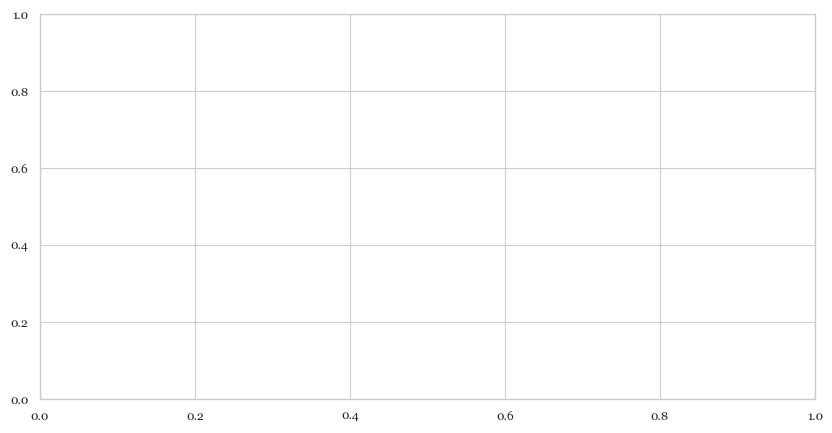

In [32]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="ProbaSlope Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
# for split in train_splits[:-1]:
#     ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "ProbaSlope Delegation Ensemble vs Full Ensemble vs Restricted Max Guru Delegation Ensemble"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [66]:
print(len(exp.ensembles))
for ens in exp.ensembles:
    print(ens.name)

50
full-ensemble
random_better-accuracy_score-num_gurus-1
random_better-accuracy_score-num_gurus-2
random_better-accuracy_score-num_gurus-3
random_better-accuracy_score-num_gurus-4
random_better-balanced_accuracy_score-num_gurus-1
random_better-balanced_accuracy_score-num_gurus-2
random_better-balanced_accuracy_score-num_gurus-3
random_better-balanced_accuracy_score-num_gurus-4
random_better-f1_score-num_gurus-1
random_better-f1_score-num_gurus-2
random_better-f1_score-num_gurus-3
random_better-f1_score-num_gurus-4
probabilistic_better-accuracy_score-num_gurus-1
probabilistic_better-accuracy_score-num_gurus-2
probabilistic_better-accuracy_score-num_gurus-3
probabilistic_better-accuracy_score-num_gurus-4
probabilistic_better-balanced_accuracy_score-num_gurus-1
probabilistic_better-balanced_accuracy_score-num_gurus-2
probabilistic_better-balanced_accuracy_score-num_gurus-3
probabilistic_better-balanced_accuracy_score-num_gurus-4
probabilistic_better-f1_score-num_gurus-1
probabilistic_bet

In [59]:
print(exp.ensembles[-5].name)
batch_accs = []
for voter in exp.ensembles[-5].voters:
    batch_accs.append(voter.batch_accuracies)
# exp.ensembles[-5].voters[0].batch_accuracies

max_diversity-f1_score-num_gurus-1


In [61]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["max_diversity-f1_score-num_gurus-1"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

[[0, 50], [53, 53], [60, 63], [70, 70], [80, 80], [82, 82], [94, 94], [96, 96], [99, 99], [178, 178], [195, 201], [267, 267], [269, 269], [293, 299], [333, 333], [361, 388]]


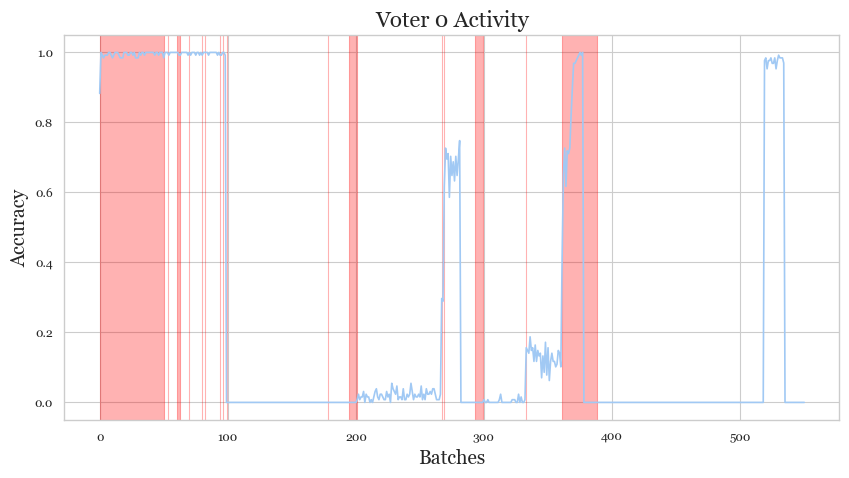

[[0, 50], [57, 57], [94, 94], [108, 108], [122, 122], [178, 178], [195, 201], [258, 258], [297, 297], [300, 302], [376, 376], [389, 470]]


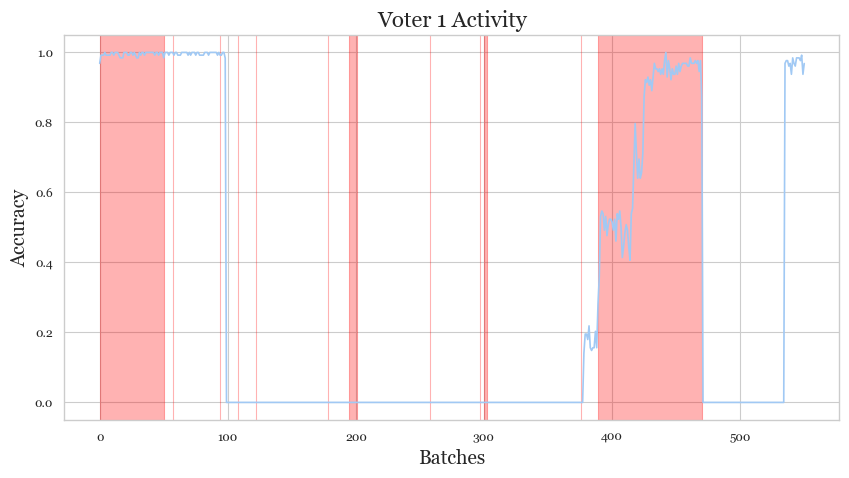

[[0, 50], [80, 81], [85, 85], [87, 87], [93, 177], [179, 194], [297, 297], [300, 302], [376, 376]]


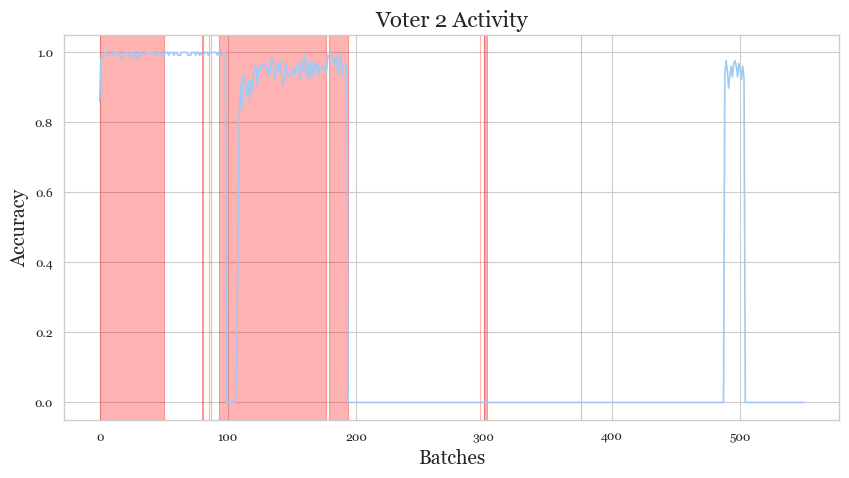

[[0, 50], [52, 52], [82, 82], [122, 122], [124, 124], [178, 178], [195, 258], [376, 376]]


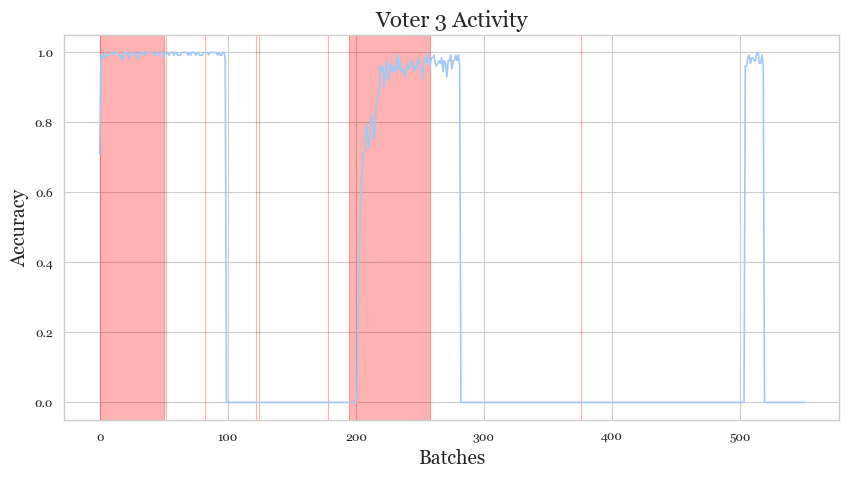

[[0, 59], [62, 62], [64, 79], [82, 84], [86, 92], [115, 115], [121, 121], [123, 123], [178, 178], [195, 201], [253, 253], [255, 255], [259, 292], [376, 376]]


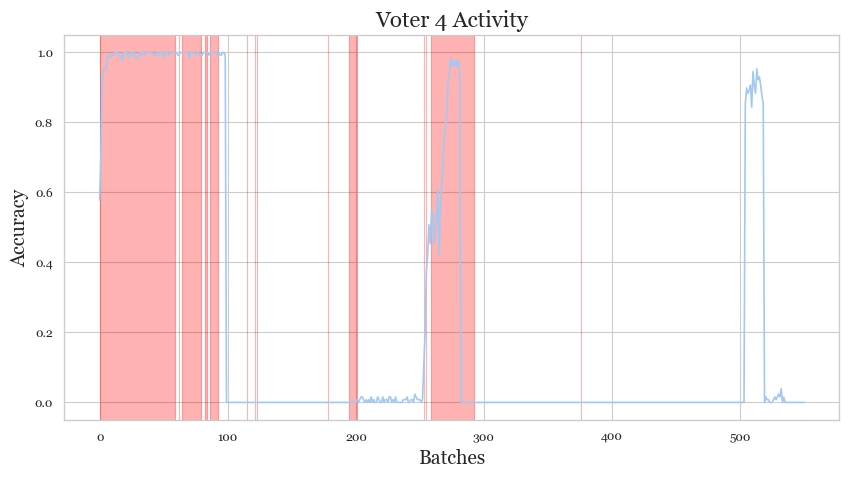

[[0, 50], [80, 80], [94, 94], [131, 131], [178, 178], [195, 201], [266, 266], [376, 376]]


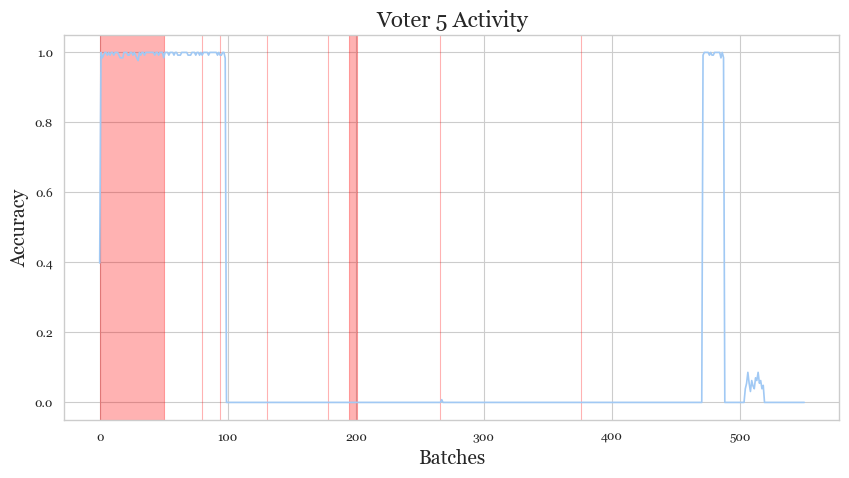

[[0, 50], [52, 52], [60, 60], [80, 80], [98, 98], [110, 110], [122, 122], [178, 178], [195, 201], [259, 259]]


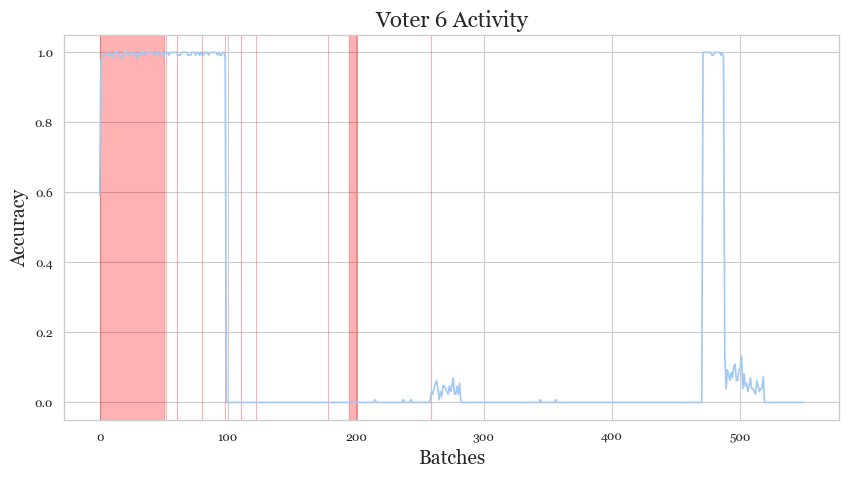

[[0, 50], [52, 52], [69, 69], [81, 81], [132, 132], [178, 178], [195, 201], [266, 266], [294, 294], [297, 297], [300, 360]]


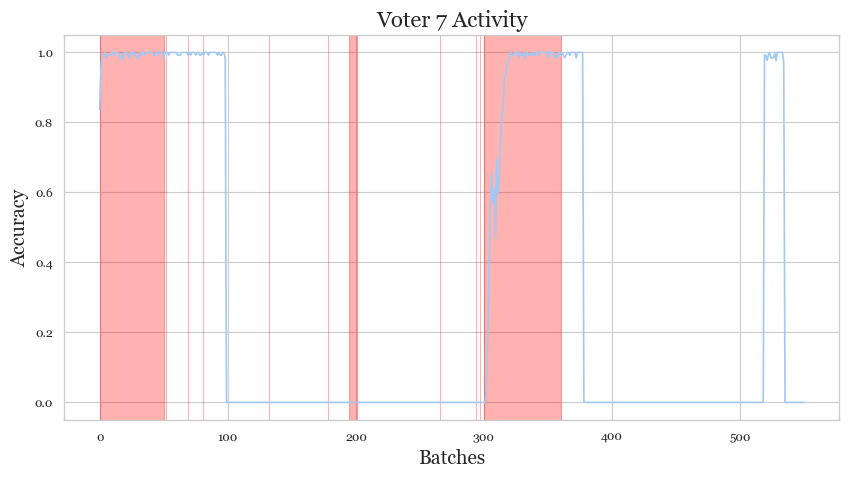

In [62]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    print(active_streaks)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    # plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    # for split in train_splits[:-1]:
    #     plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter